# Sebastian Garcia
# Word Embeddings and t-SNE
A dataset of 10,000 English job ads from job.ch is provided. Your task is to use the word2vec model of the gensim package to map words from the vocabulary to vectors of real numbers. Use t-SNE as a way to visualize these word embeddings. There is a helper file provided in the materials section.

Like in any classical NLP task the steps in this analysis are:

- Clean the data, remove stop words

- Build a corpus

- Build and train a Word2Vec model

- Visualize the resulting model using t-SNE

Bonus:

- Extract the 100 most similar words to a certain given word (e.g. ‘python’)

- Visualize the result with t-SNE

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import word2vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")


C:\Users\okupa\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
df = pd.read_csv('job_ads_eng.csv')
df.head()


,Keywords,Job title,Date published,Alive until,Company name,Location,Company type,Contract type,Occupation,Job rank,Content,Industry,Official website,Canton initials,Canton name
0,ICT System Engineer,System Engineer,2019-05-27 00:00:00,2019-06-05 00:00:00,Harvey Nash AG,Zürich,Consultants,Unlimited employment,100,Employee,System EngineerJob Description Overview of b...,"Recruitment agency, Staffing",http://www.harveynash.com/ch,ZH,Zurich
1,Automation Engineer,Automation Engineer with DeltaV,2019-04-23 00:00:00,2019-05-03 00:00:00,Spring Professional Engineering,Sion,Consultants,Unlimited employment,100,Position with responsibilities,Ihre Herausforderung You plan and implement A...,"Recruitment agency, Staffing",https://www.springprofessional.ch/,VS,Valais
2,Development Engineer,Junior Development Engineer 100% (m/f/d),2019-05-08 00:00:00,2019-05-24 00:00:00,Zentra AG Ihr Jobprofi,Canton of Zug,Consultants,Unlimited employment,Temporary,Position with responsibilities,Since 1989 - more than a quarter of a centur...,"Recruitment agency, Staffing",http://www.zentra.ch,ZG,Zug
3,Contract Analyst,Contract & Commercial Manager,2019-06-14 00:00:00,2019-06-24 00:00:00,Huawei Technologies Switzerland AG,Dübendorf ZH,Large-scale entreprises,Unlimited employment,100,Position with responsibilities,Huawei is a leading global provider of informa...,"Information technology, Telecom.",http://www.huawei.com/,ZH,Zurich
4,Executive Assistant,Executive Assistant 100 %,2019-06-19 00:00:00,2019-06-24 00:00:00,Habasit AG,Reinach,Small and medium-sized enterprises,Unlimited employment,100,Employee,Executive Assistant 100 %Habasit is an interna...,Industry various,http://www.habasit.com,BL,Basel


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
Keywords            10000 non-null object
Job title           10000 non-null object
Date published      9942 non-null object
Alive until         10000 non-null object
Company name        7940 non-null object
Location            9994 non-null object
Company type        7891 non-null object
Contract type       10000 non-null object
Occupation          9989 non-null object
Job rank            9999 non-null object
Content             10000 non-null object
Industry            7929 non-null object
Official website    7467 non-null object
Canton initials     9293 non-null object
Canton name         9293 non-null object
dtypes: object(15)
memory usage: 1.1+ MB


# Noise Removal

In [4]:
text_corpus = df.Content.values.tolist()
text_corpus = [re.sub(r'\s', ' ', str(text)) for text in text_corpus] # replace all whitespace characters by ' '
text_corpus = [re.sub(r'\S*@\S*\s?', '', doc) for doc in text_corpus] #removing email addresses
text_corpus = [re.sub('\s+', ' ', doc) for doc in text_corpus] #removing newline characters
text_corpus = [re.sub("\'", "", doc) for doc in text_corpus] #removing single quote characters
text_corpus = [re.sub("\d", "", doc) for doc in text_corpus] #removing numbers
text_corpus = [re.sub(r'\b\w{1,3}\b', '', doc) for doc in text_corpus] #removing short words
text_corpus[0]


'System EngineerJob Description Overview  business area  project: Resource will work  strategic programs   Enterprise Services Department   entire Chief Technology Office within  Bank.   deliveries  based  ServiceNow platform   MidServer infrastructure  consists  Configuration Management Database (CMDB) with multiple automatic  semiautomatic integrations with various tools  applications.  Responsibilities:  have  exciting opportunity  lead ServiceNow Data Integration Engineering stream including development  maintenance  ServiceNow MidServer infrastructure, executing changes & analysis  incidents  problem tickets. Your role includes deep troubleshooting  complex issues down  code level.  this open position,  have  responsibility    Subject Matter Expert & Lead Point  Contact   data transformation scripts built  PERL.    chance  become part   specialized  highly motivated ServiceNow team   build  maintain positive relationships with many different teams such  product owners, internal cu

In [5]:
len(text_corpus)


10000

# Tokenization

In [6]:
def doc_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
 
words = list(doc_to_words(text_corpus))
 
words[0]


['system',
 'engineerjob',
 'description',
 'overview',
 'business',
 'area',
 'project',
 'resource',
 'will',
 'work',
 'strategic',
 'programs',
 'enterprise',
 'services',
 'department',
 'entire',
 'chief',
 'technology',
 'office',
 'within',
 'bank',
 'deliveries',
 'based',
 'servicenow',
 'platform',
 'midserver',
 'infrastructure',
 'consists',
 'configuration',
 'management',
 'database',
 'cmdb',
 'with',
 'multiple',
 'automatic',
 'semiautomatic',
 'integrations',
 'with',
 'various',
 'tools',
 'applications',
 'have',
 'exciting',
 'opportunity',
 'lead',
 'servicenow',
 'data',
 'integration',
 'engineering',
 'stream',
 'including',
 'development',
 'maintenance',
 'servicenow',
 'midserver',
 'infrastructure',
 'executing',
 'changes',
 'analysis',
 'incidents',
 'problem',
 'tickets',
 'your',
 'role',
 'includes',
 'deep',
 'troubleshooting',
 'complex',
 'issues',
 'down',
 'code',
 'level',
 'this',
 'open',
 'position',
 'have',
 'responsibility',
 'subject',
 '

# Lexicon normalization

Stopwords removal

In [7]:
stop_words = stopwords.words('english')
stop_words.extend(['therefore', 'name', 'general', 'in particular', 'only'])
 
def remove_stopwords(text):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in text_corpus]
 
corpus = remove_stopwords(words)
 
corpus[0]


['system',
 'engineerjob',
 'description',
 'overview',
 'business',
 'area',
 'project',
 'resource',
 'work',
 'strategic',
 'programs',
 'enterprise',
 'services',
 'department',
 'entire',
 'chief',
 'technology',
 'office',
 'within',
 'bank',
 'deliveries',
 'based',
 'servicenow',
 'platform',
 'midserver',
 'infrastructure',
 'consists',
 'configuration',
 'management',
 'database',
 'cmdb',
 'multiple',
 'automatic',
 'semiautomatic',
 'integrations',
 'various',
 'tools',
 'applications',
 'exciting',
 'opportunity',
 'lead',
 'servicenow',
 'data',
 'integration',
 'engineering',
 'stream',
 'including',
 'development',
 'maintenance',
 'servicenow',
 'midserver',
 'infrastructure',
 'executing',
 'changes',
 'analysis',
 'incidents',
 'problem',
 'tickets',
 'role',
 'includes',
 'deep',
 'troubleshooting',
 'complex',
 'issues',
 'code',
 'level',
 'open',
 'position',
 'responsibility',
 'subject',
 'matter',
 'expert',
 'lead',
 'point',
 'contact',
 'data',
 'transforma

# Word2Vec

In [8]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=500, workers=4)
model.wv['machine']


array([-1.640857  ,  2.7653382 , -0.7174467 , -1.5576738 ,  0.15397917,
        1.2634635 ,  0.6816929 , -0.05033491,  5.936859  , -2.6895401 ,
        1.8972319 , -2.159469  , -0.59641194,  1.7762824 ,  0.51469934,
        3.1315763 ,  1.0996463 , -0.41426814,  0.29817942, -1.481729  ,
       -2.7629647 ,  1.1095462 ,  0.76370466, -3.9575894 , -3.8800354 ,
        1.333756  ,  1.1309626 , -0.46669877,  1.7416314 ,  0.83623385,
       -2.1555974 , -0.5127304 ,  0.524389  , -3.660439  ,  1.8737371 ,
        0.83283466,  1.1561257 , -0.6677815 ,  1.7264729 ,  3.6017134 ,
        0.7308527 , -1.1445811 , -0.48640797, -2.585167  ,  1.9003778 ,
        1.1146255 ,  1.0512148 , -1.7769933 ,  5.7166986 ,  1.9616429 ,
       -0.8148538 ,  1.6454546 ,  2.6055343 ,  2.7522292 , -4.1311936 ,
       -4.8950734 ,  2.344855  ,  0.1441576 ,  1.326157  ,  0.21469681,
       -1.7947218 , -1.4212183 ,  0.47749174,  1.6527578 ,  1.1463376 ,
        1.2404867 ,  1.1892226 ,  1.2521389 , -3.2208245 ,  1.21

In [9]:
model.wv.vocab


{'system': <gensim.models.keyedvectors.Vocab at 0x1c98ec4a320>,
 'description': <gensim.models.keyedvectors.Vocab at 0x1c995cb3ba8>,
 'business': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a5cf8>,
 'area': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a57f0>,
 'project': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a5c18>,
 'resource': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a5c88>,
 'work': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a5c50>,
 'strategic': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a5a90>,
 'programs': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a5b70>,
 'enterprise': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a5be0>,
 'services': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a5ba8>,
 'department': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a5ac8>,
 'technology': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a5b00>,
 'office': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a5b38>,
 'within': <gensim.models.keyedvectors.Vocab at 0x1c9ad2a5710>,
 'bank': <gensi

In [36]:
#find the word most similar
model.wv.most_similar(positive=["machine"], topn=10)


[('learning', 0.6895317435264587),
 ('statistics', 0.5501127243041992),
 ('processing', 0.5291287899017334),
 ('techniques', 0.5094259977340698),
 ('python', 0.4961460828781128),
 ('intelligence', 0.4597773849964142),
 ('statistical', 0.45088085532188416),
 ('physics', 0.45025724172592163),
 ('programming', 0.44326478242874146),
 ('quantitative', 0.44324010610580444)]

In [38]:
#find the word less similar
model.wv.most_similar(negative=["machine"], topn=10)


[('country', 0.31896641850471497),
 ('organization', 0.31486833095550537),
 ('contracts', 0.30568158626556396),
 ('assigned', 0.2992483675479889),
 ('stakeholder', 0.29602351784706116),
 ('organisation', 0.29367852210998535),
 ('matrix', 0.28993380069732666),
 ('requests', 0.2766406536102295),
 ('function', 0.27346616983413696),
 ('package', 0.2720964550971985)]

In [11]:
#how similar are two words to each other
model.wv.similarity("machine", 'engineering')


0.19438704085096226

In [12]:
#the word that does not belong to the list!
model.wv.doesnt_match(['machine', 'learning', 'python'])


'python'

# t-SNE visualizations:

In [13]:
def tsne_plot(model):
   "Creates and TSNE model and plots it"
   labels = []
   tokens = []

   for word in model.wv.vocab:
       tokens.append(model[word])
       labels.append(word)

   tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
   new_values = tsne_model.fit_transform(tokens)

   x = []
   y = []
   for value in new_values:
       x.append(value[0])
       y.append(value[1])

   plt.figure(figsize=(16, 16))
   for i in range(len(x)):
       plt.scatter(x[i],y[i])
       plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
   plt.show()


C:\Users\okupa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


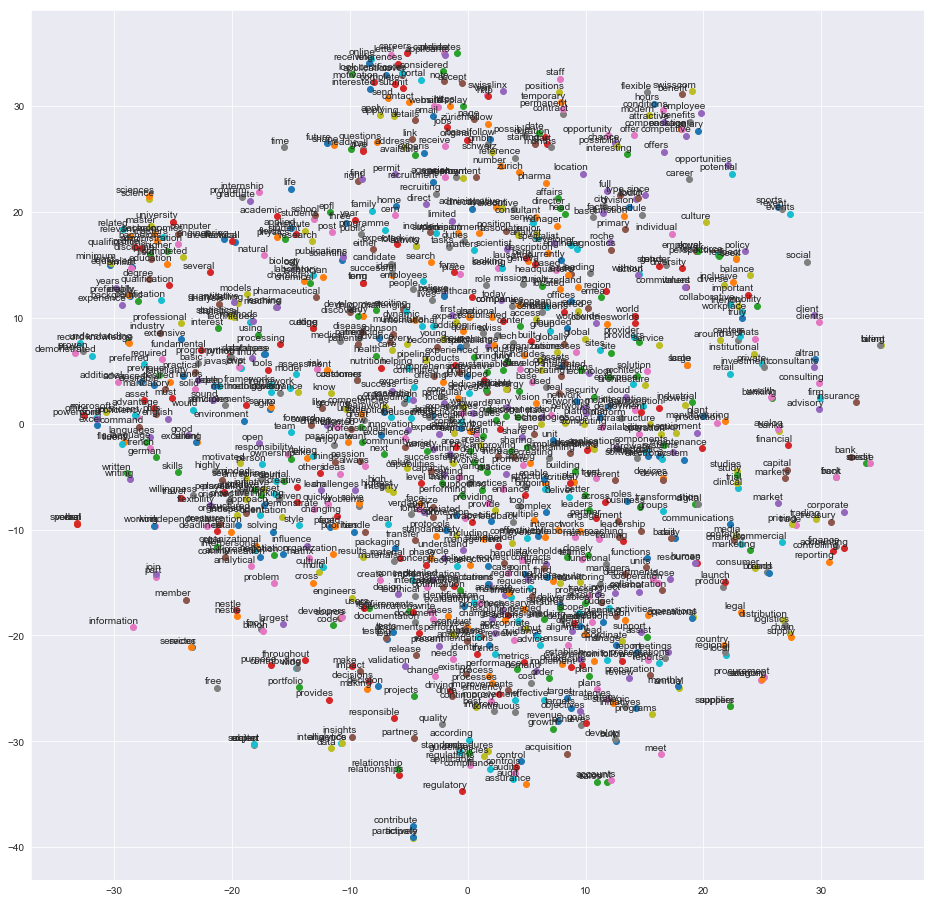

In [14]:
tsne_plot(model)


In [62]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 100 to 19 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(10, 10)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    #plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    #plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))


#### 10 Most similar words vs. 10 Most dissimilar:

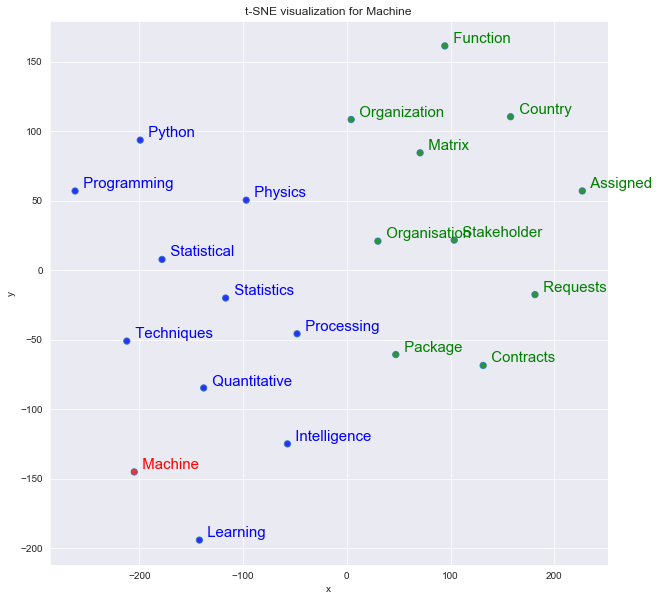

In [63]:
tsnescatterplot(model, 'machine', [i[0] for i in model.wv.most_similar(negative=["machine"])])


#### 100 Most similar words

In [64]:
model.wv.most_similar(positive=["machine"], topn=100)


[('learning', 0.6895317435264587),
 ('statistics', 0.5501127243041992),
 ('processing', 0.5291287899017334),
 ('techniques', 0.5094259977340698),
 ('python', 0.4961460828781128),
 ('intelligence', 0.4597773849964142),
 ('statistical', 0.45088085532188416),
 ('physics', 0.45025724172592163),
 ('programming', 0.44326478242874146),
 ('quantitative', 0.44324010610580444),
 ('modelling', 0.4407687783241272),
 ('using', 0.4366368055343628),
 ('vision', 0.43228429555892944),
 ('applied', 0.41985201835632324),
 ('methods', 0.4097558557987213),
 ('fields', 0.40503719449043274),
 ('generation', 0.4050319790840149),
 ('data', 0.3933212161064148),
 ('computing', 0.3714311718940735),
 ('technologies', 0.37000706791877747),
 ('student', 0.3672226071357727),
 ('analytics', 0.36121875047683716),
 ('analysis', 0.35756102204322815),
 ('interest', 0.35689952969551086),
 ('practical', 0.343769371509552),
 ('computer', 0.3365976810455322),
 ('deep', 0.3346601128578186),
 ('advanced', 0.326493501663208),
 (

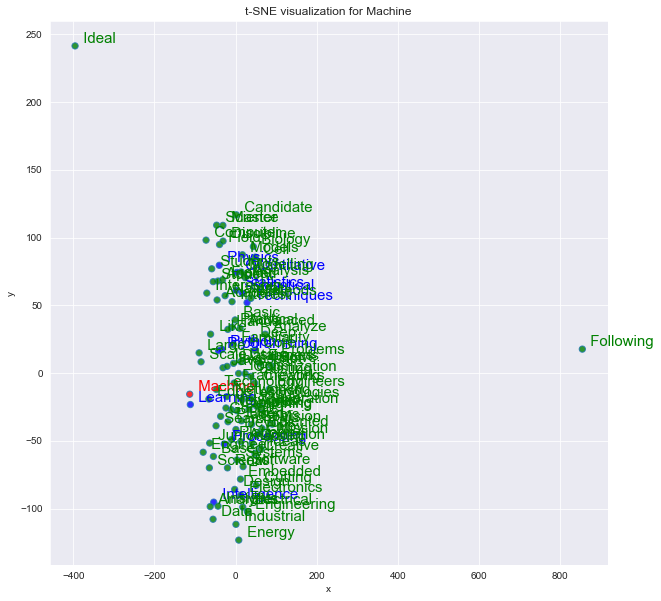

In [65]:
tsnescatterplot(model, "machine", [t[0] for t in model.wv.most_similar(positive=["machine"], topn=100)][10:])
